<a href="https://colab.research.google.com/github/hafizapatel04-bit/f1_Prediction/blob/main/AbuDhabiGP2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
#abu dhabi grandprix prediction

In [3]:
!pip install fastf1 xgboost scikit-learn matplotlib pandas numpy lxml requests

import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.0/123.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.8 MB/s eta 0:00:00
  Created wheel for msgpack: filename=msgpack-1.0.2-cp312-cp312-linux_x86_64.whl size=15820 sha256=14d9edb4a3fd91beac54a3c342f8a5aee17ea3b5ebb38419a11c9c9eb15f79e0
  Stored in directory: /root/.cache/pip/wheels/67/a6/40/eda0983e595bbf3841af96dbff2340be72dfac96796fc3d578
Successfully built msgpack
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.1.2
    Uninstalling msgpack-1.1.2:
      Successfully uninstalled msgpack-1.1.2
  Attempting uninstall: websocket

In [4]:
import fastf1
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor


In [12]:
session_2024 = fastf1.get_session(2024, 24, "R")
session_2024.load()

req         WARNING 	DEFAULT CACHE ENABLED! (24.0 KB) /root/.cache/fastf1
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.7.0]
INFO:fastf1.fastf1.core:Loading data for Abu Dhabi Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:58:03.658' in Ergas

In [13]:
laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_2024.dropna(inplace=True)

In [16]:
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()


In [17]:

# aggregate sector times by driver
sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()

sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)

# clean air race pace from racepace.py
clean_air_race_pace = {
    "VER": 93.191067, "HAM": 94.020622, "LEC": 93.418667, "NOR": 93.428600, "ALO": 94.784333,
    "PIA": 93.232111, "RUS": 93.833378, "SAI": 94.497444, "STR": 95.318250, "HUL": 95.345455,
    "OCO": 95.682128
}

In [18]:

# quali data from Abu Dhabi GP
qualifying_2025 = pd.DataFrame({
    "Driver": ["RUS", "VER", "PIA", "NOR", "HAM", "LEC", "ALO", "HUL", "ALB", "SAI", "STR", "OCO", "GAS"],
    "QualifyingTime (s)": [
        82.645,  # RUS
        82.207,  # VER
        82.437,  # PIA
        82.408,  # NOR
        83.394,  # HAM
        82.730,  # LEC
        82.902,  # ALO
        83.450,  # HUL
        83.416,  # ALB
        83.042,  # SAI
        83.097,  # STR
        82.913,  # OCO
        83.468   # GAS
    ]
})

In [22]:

# Abu Dhabi is almost always dry and warm during the GP

rain_probability = 0.0   # assume dry race, no rain
temperature = 25.0       # typical race weekend track conditions (°C)

print("Weather module skipped.")
print(f"Rain Probability: {rain_probability}")
print(f"Temperature: {temperature}°C")


Weather module skipped.
Rain Probability: 0.0
Temperature: 25.0°C


In [23]:
# adjust qualifying time based on weather conditions
if rain_probability >= 0.75:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"] * qualifying_2025["WetPerformanceFactor"]
else:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]


In [24]:
# add constructor's data
team_points = {
    "McLaren": 800, "Mercedes": 459, "Red Bull": 426, "Williams": 137, "Ferrari": 382,
    "Haas": 73, "Aston Martin": 80, "Kick Sauber": 68, "Racing Bulls": 92, "Alpine": 22
}


In [25]:
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}

driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Ferrari", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Williams", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}

qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)


In [26]:
# merge qualifying and sector times data
merged_data = qualifying_2025.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature
merged_data["QualifyingTime"] = merged_data["QualifyingTime"]


valid_drivers = merged_data["Driver"].isin(laps_2024["Driver"].unique())
merged_data = merged_data[valid_drivers]


In [27]:
# define features (X) and target (y)
X = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore",
    "CleanAirRacePace (s)"
]]
y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])

# impute missing values for features
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.1, random_state=39)

# train XGBoost model
model = XGBRegressor(n_estimators=300, learning_rate=0.9, max_depth=3, random_state=39,  monotone_constraints='(1, 0, 0, -1, -1)')
model.fit(X_train, y_train)
merged_data["PredictedRaceTime (s)"] = model.predict(X_imputed)

In [28]:

# sort the results to find the predicted winner
final_results = merged_data.sort_values(by=["PredictedRaceTime (s)", "QualifyingTime"]).reset_index(drop=True)
print(final_results[["Driver", "PredictedRaceTime (s)"]])


   Driver  PredictedRaceTime (s)
0     VER              89.512421
1     NOR              89.512421
2     PIA              89.512421
3     SAI              89.649284
4     RUS              90.031982
5     LEC              90.031982
6     HAM              90.168396
7     HUL              90.761429
8     ALB              90.787804
9     ALO              90.789551
10    STR              91.037865
11    GAS              91.101997


In [29]:

# sort results and get top 3
podium = final_results.loc[:7, ["Driver", "PredictedRaceTime (s)"]]
print("\n🏆 Predicted in the Top 3 🏆")
print(f"🥇 P1: {podium.iloc[0]['Driver']}")
print(f"🥈 P2: {podium.iloc[1]['Driver']}")
print(f"🥉 P3: {podium.iloc[2]['Driver']}")
y_pred = model.predict(X_test)
print(f"Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")



🏆 Predicted in the Top 3 🏆
🥇 P1: VER
🥈 P2: NOR
🥉 P3: PIA
Model Error (MAE): 0.99 seconds


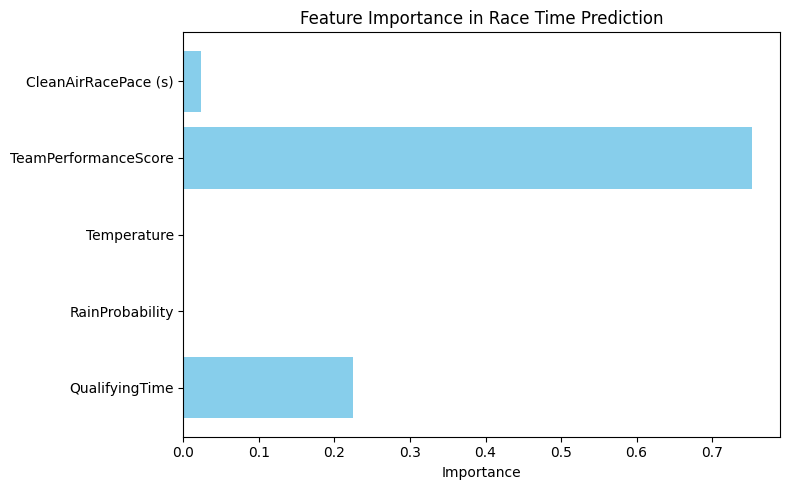

In [30]:

# Plot feature importances
feature_importance = model.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance in Race Time Prediction")
plt.tight_layout()
plt.show()

/tmp/ipython-input-1422738954.py:30: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


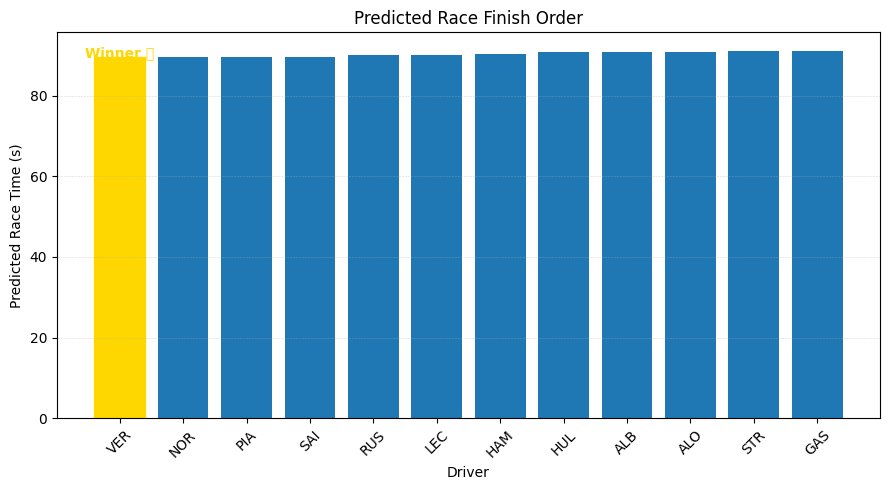

In [34]:
# --- Predicted Winner Plot (Corrected Source) ---

predicted_times = final_results.sort_values("PredictedRaceTime (s)").reset_index(drop=True)
winner = predicted_times.iloc[0]

plt.figure(figsize=(9, 5))

# bar plot
bars = plt.bar(predicted_times["Driver"], predicted_times["PredictedRaceTime (s)"])

# highlight winner in a different color
bars[0].set_color("gold")

plt.xlabel("Driver")
plt.ylabel("Predicted Race Time (s)")
plt.title("Predicted Race Finish Order")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", linewidth=0.4, alpha=0.5)

# label winner
plt.text(
    winner["Driver"],
    winner["PredictedRaceTime (s)"] + 0.05,
    "Winner 🏆",
    ha="center",
    fontweight="bold",
    color="gold"
)

plt.tight_layout()
plt.show()


/tmp/ipython-input-871945765.py:34: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


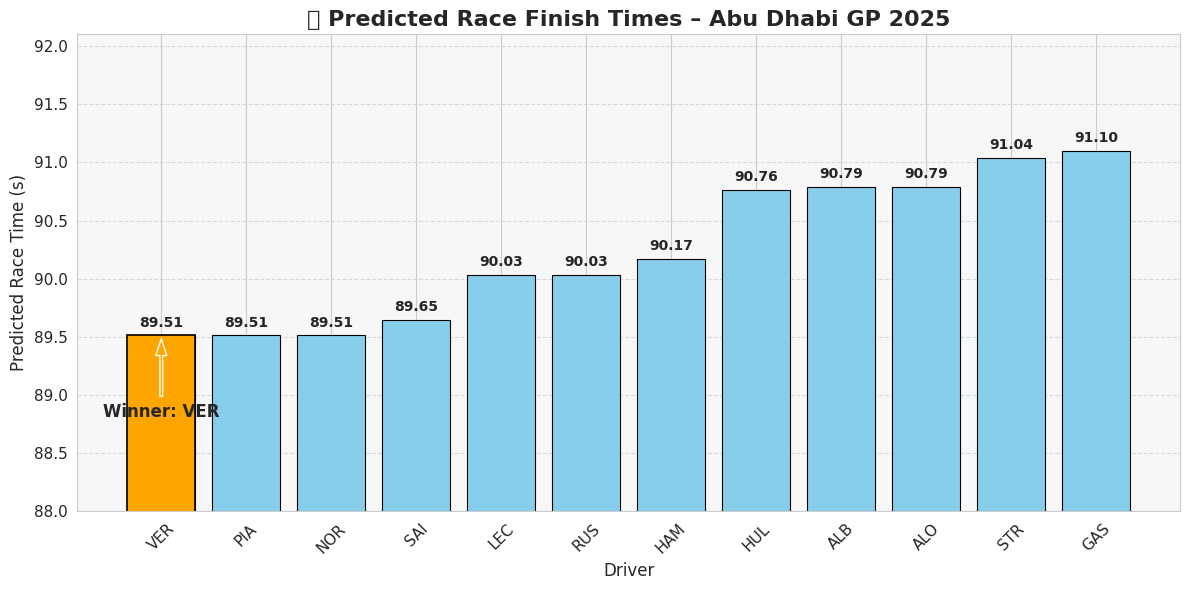

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
predicted_times = merged_data.sort_values("PredictedRaceTime (s)").reset_index(drop=True)
winner = predicted_times.iloc[0]

# --- Plotting ---
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
palette = ["gold" if driver == winner["Driver"] else "skyblue" for driver in predicted_times["Driver"]]

bars = plt.bar(predicted_times["Driver"], predicted_times["PredictedRaceTime (s)"], color=palette, edgecolor='black', linewidth=0.8)

# Highlight winner
plt.bar(winner["Driver"], winner["PredictedRaceTime (s)"], color="orange", edgecolor='black', linewidth=1.2)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f"{yval:.2f}", ha='center', va='bottom', fontweight='bold', fontsize=10)

# Title and labels
plt.title("🏁 Predicted Race Finish Times – Abu Dhabi GP 2025", fontsize=16, fontweight='bold')
plt.xlabel("Driver", fontsize=12)
plt.ylabel("Predicted Race Time (s)", fontsize=12)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(88, max(predicted_times["PredictedRaceTime (s)"]) + 1)

# Grid and background
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_facecolor("#f7f7f7")
plt.tight_layout()

# Annotate winner
plt.annotate(
    f"Winner: {winner['Driver']}",
    xy=(winner.name, winner["PredictedRaceTime (s)"]),
    xytext=(winner.name, winner["PredictedRaceTime (s)"] - 0.7),
    ha='center',
    fontweight='bold',
    fontsize=12,
    arrowprops=dict(facecolor='orange', shrink=0.05, width=2, headwidth=8)
)

plt.show()
